In [1]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pathvalidate

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install plot_keras_history

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
import os
import shutil
import time
from pathvalidate import sanitize_filename
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from plot_keras_history import show_history, plot_history

import matplotlib.pyplot as plt
import seaborn as sns


2023-06-01 16:32:41.518474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
batch_size = 32

# Préparation des données

On commence par préparer le dossier d'images. En effet, toutes les images sont mélangées dans le même dossier, or la fonction que nous allons utiliser 
tf.keras.utils.image_dataset_from_directory s'attend à un sous-répertoire par catégorie

In [7]:
df = pd.read_parquet("../../etude_classification_texte/working/cleaned.parquet")
df_train = pd.read_parquet("../df_train.parquet")
df_test = pd.read_parquet("../df_test.parquet")

In [8]:
df_train

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
index,,,,,,,,,,,,,,,,,,
240,7e4c1d31e279a700c6b8e66d820e8601,2015-12-01 12:40:44 +0000,http://www.flipkart.com/kosher-kadhai-5-l/p/it...,Kosher Kadhai 5 L,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",PTPEANCHNPTDUUQK,592.0,592.0,7e4c1d31e279a700c6b8e66d820e8601.jpg,False,Buy Kosher Kadhai 5 L for Rs.592 online. Koshe...,No rating available,No rating available,Kosher,"{""product_specification""=>[{""key""=>""Brand"", ""v...",kitchen & dining,kadhai,kadhai kadhai best
516,d77279c8268e231b685cdbaf299e83f2,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-7016ym09-watch/...,Sonata 7016YM09 Watch,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATDZ2ZQK6VS9DB4,968.0,968.0,d77279c8268e231b685cdbaf299e83f2.jpg,False,Sonata 7016YM09 Watch - Buy Sonata 7016YM09 Wa...,No rating available,No rating available,None,"{""product_specification""=>{""key""=>""Style Code""...",watches,sonata watch,sonata watch sonata watch india great
117,be09f5a3a88ac10ae14c791fc8ac0dae,2016-01-03 09:39:44 +0000,http://www.flipkart.com/anthill-baby-boy-s-gir...,"Anthill Baby Boy's, Baby Girl's Bodysuit","[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BOLEDQ9GWZHESQF8,405.0,405.0,be09f5a3a88ac10ae14c791fc8ac0dae.jpg,False,"Anthill Baby Boy's, Baby Girl's Bodysuit - Buy...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Age Group""...",baby care,anthil babi babi girl bodysuit,anthil babi babi girl bodysuit yellow anthil b...
739,52877a6306aef18af67ab54c8233c931,2016-04-21 16:46:08 +0000,http://www.flipkart.com/buyer-s-beach-bb349/p/...,Buyer's Beach BB349,"[""Kitchen & Dining >> Dinnerware & Crockery >>...",CNSEHWGRNCSHGNPC,999.0,449.0,52877a6306aef18af67ab54c8233c931.jpg,False,Buyer's Beach BB349 (Brown) Price: Rs. 449 Sty...,No rating available,No rating available,Buyer's Beach,"{""product_specification""=>[{""key""=>""Brand"", ""v...",kitchen & dining,,brown stylish everi discern multicolor procur ...
882,a6c820b76bc29bbe2d85eecad3de03f8,2015-12-20 08:26:17 +0000,http://www.flipkart.com/mandhania-cotton-bath-...,Mandhania Cotton Bath Towel,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWE5QUGZHGG8YZH,490.0,280.0,a6c820b76bc29bbe2d85eecad3de03f8.jpg,False,Buy Mandhania Cotton Bath Towel at Rs. 280 at ...,5,5,Mandhania,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,cotton bath towel,cotton bath towel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,a18d4ddb1a1c3463d6719e526573c4ba,2015-12-12 11:46:53 +0000,http://www.flipkart.com/rajasthan-crafts-abstr...,Rajasthan Crafts Abstract Single Quilts & Comf...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAE8YHUYQG5JBBF,950.0,840.0,a18d4ddb1a1c3463d6719e526573c4ba.jpg,False,Buy Rajasthan Crafts Abstract Single Quilts & ...,3,3,Rajasthan Crafts,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,abstract singl quilt comfort multicolor,abstract singl quilt comfort multicolor
44,8050d31bffe6827c804b8222338aafb2,2016-03-20 14:44:44 +0000,http://www.flipkart.com/akup-i-loves-music-cer...,AKUP i-loves-music Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> AKUP Coff...",MUGEGZUHVZ4Y85DV,500.0,259.0,8050d31bffe6827c804b8222338aafb2.jpg,False,Key Features of AKUP i-loves-music Ceramic Mug...,No rating available,No rating available,AKUP,"{""product_specification""=>[{""key""=>""Type"", ""va...",kitchen & dining,ceram,ceram ceram ceram coffe give best love provid ...
674,2bf0ca6d25501c067cd12a2a4939443f,2015-12-31 09:19:31 +0000,http://www.flipkart.com/home-fashion-gallery-p...,Home Fashion Gallery Polyester Black Plain Eye...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNECSYF7U72GEQH,2498.0,1499.0,2bf0ca6d2

In [9]:
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical',
        class_names=None, batch_size=batch_size, image_size=(299,299), shuffle=True,
        validation_split=validation_split, subset=data_type, seed=42
    )
    return dataset

In [10]:
dataset_train = dataset_fct("../assets/train", validation_split=0.25, data_type='training')
dataset_val = dataset_fct("../assets/train", validation_split=0.25, data_type='validation')
dataset_test = dataset_fct("../assets/test", validation_split=0, data_type=None)


Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 7 classes.


2023-06-01 16:32:43.802389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:32:43.810310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:32:43.810618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Création du modèle

In [11]:
def create_model() :
    # Data augmentation : les fonctions de data augmentations ne sont actives que durant les fit
    data_augmentation = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(299, 299, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = tf.keras.models.Sequential([
        data_augmentation,
        tf.keras.layers.Lambda(tf.keras.applications.inception_resnet_v2.preprocess_input, input_shape=(299, 299, 3)),
        tf.keras.layers.Rescaling(1./127.5, offset=-1),
        model_base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    return model


In [12]:
model = create_model()

In [13]:
model_save_path = "./model_best_weights_inceptionresnet.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Entrainement

In [14]:
t0 = time.time()
history = model.fit(dataset_train,
          validation_data=dataset_val,
          batch_size=32, epochs=100, callbacks=[checkpoint_cb, earlystopping_cb], verbose=1)
print(f"Durée de l'entrainement: {time.time() - t0}")

Epoch 1/100


2023-06-01 16:32:50.601994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [591]
	 [[{{node Placeholder/_4}}]]
2023-06-01 16:32:50.602501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [591]
	 [[{{node Placeholder/_0}}]]
2023-06-01 16:32:59.801262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-01 16:33:05.568181: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this

18/19 [===========================>..] - ETA: 0s - loss: 2.0643 - accuracy: 0.1806

2023-06-01 16:33:21.477615: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/19 [==============================] - ETA: 0s - loss: 2.0561 - accuracy: 0.1844

2023-06-01 16:33:22.360007: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-01 16:33:22.394531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [196]
	 [[{{node Placeholder/_0}}]]
2023-06-01 16:33:22.394843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [196]
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.96478, saving model to ./model_best_weights_inceptionresnet.h5
19/19 [==============================] - 42s 1s/step - loss: 2.0561 - accuracy: 0.1844 - val_loss: 1.9648 - val_accuracy: 0.2194
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 1.8813 - accuracy: 0.2657
Epoch 2: val_loss improved from 1.96478 to 1.81949, saving model to ./model_best_weights_inceptionresnet.h5
19/19 [==============================] - 19s 973ms/step - loss: 1.8813 - accuracy: 0.2657 - val_loss: 1.8195 - val_accuracy: 0.3112
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 1.8182 - accuracy: 0.2775
Epoch 3: val_loss improved from 1.81949 to 1.80816, saving model to ./model_best_weights_inceptionresnet.h5
19/19 [==============================] - 19s 972ms/step - loss: 1.8182 - accuracy: 0.2775 - val_loss: 1.8082 - val_accuracy: 0.2857
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 1.7565 - accuracy: 0.3012
E

# Evaluation

In [15]:
loss, accuracy = model.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 13s 627ms/step - loss: 1.0377 - accuracy: 0.6362
Training Accuracy   : 0.6362

7/7 [==============================] - 5s 559ms/step - loss: 1.3709 - accuracy: 0.5357
Validation Accuracy :  0.5357


In [16]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Loss     :  {:.4f}".format(loss))


Validation Accuracy :  0.5306
Validation Loss     :  1.3248


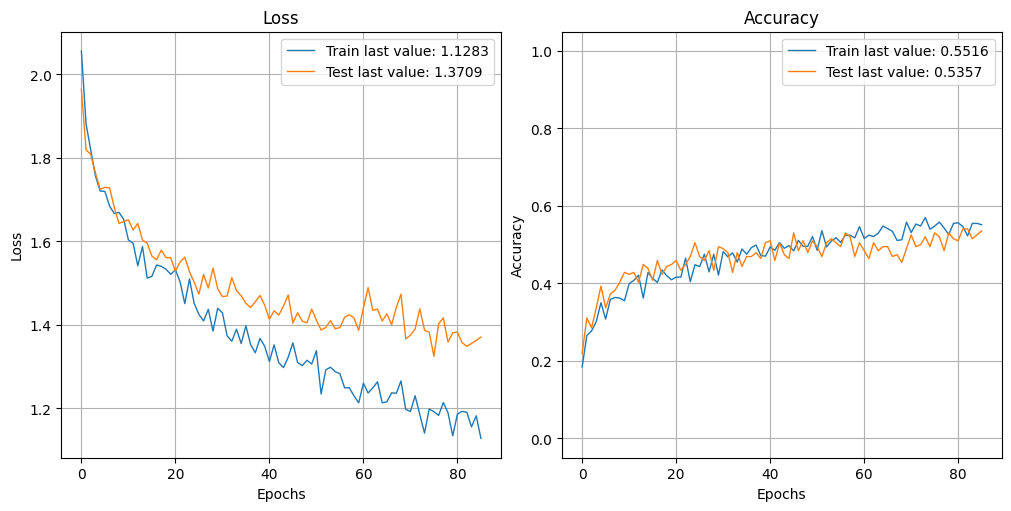

In [17]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

Calculons sur l'ensemble de test

In [18]:
loss, accuracy = model.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss           :  {:.4f}".format(loss))

2023-06-01 16:59:48.994898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [263]
	 [[{{node Placeholder/_4}}]]
2023-06-01 16:59:48.995267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [263]
	 [[{{node Placeholder/_0}}]]


Test Accuracy       :  0.4715
Test Loss           :  1.4476


# Conclusion

In [19]:
dataset_test.class_names

['baby care',
 'beauty and personal care',
 'computers',
 'home decor & festive needs',
 'home furnishing',
 'kitchen & dining',
 'watches']

In [20]:
df_test.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
index,,,,,,,,,,,,,,,,,,
830,4354b7418ee0fab2fd9f8eb493556529,2015-12-29 05:07:38 +0000,http://www.flipkart.com/memore-portable-flexib...,Memore Portable and Flexible MMULL-White USB L...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEE3GGGGYWM8ZZ,499.0,195.0,4354b7418ee0fab2fd9f8eb493556529.jpg,False,Memore Portable and Flexible MMULL-White USB L...,No rating available,No rating available,Memore,"{""product_specification""=>[{""key""=>""Lamp Adjus...",computers,portabl flexibl light,portabl flexibl light white high read light we...
883,7bbcbd91b8865a9f7b254760e5e2e10a,2015-12-20 08:26:17 +0000,http://www.flipkart.com/shagun-gold-tea-tree-e...,Shagun Gold Tea Tree Essential Aroma Therapy Oil,"[""Baby Care >> Baby Grooming >> Baby Massage O...",MSOE7D95ZBVSDKSX,296.0,269.0,7bbcbd91b8865a9f7b254760e5e2e10a.jpg,False,Shagun Gold Tea Tree Essential Aroma Therapy O...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Organic Ty...",baby care,shagun gold tree essenti aroma therapi,shagun gold tree essenti aroma therapi tree de...
789,389197b67a189c703f3deb9ca6f1f678,2015-12-12 11:46:53 +0000,http://www.flipkart.com/love-baby-cartoon-set-...,Love Baby Cartoon Set of Towels,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWDN9FZJWX4TBMZ,638.0,425.0,389197b67a189c703f3deb9ca6f1f678.jpg,False,Buy Love Baby Cartoon Set of Towels at Rs. 425...,4.3,4.3,Love Baby,"{""product_specification""=>[{""key""=>""Material"",...",baby care,cartoon towel,cartoon towel
820,00d84a518e0550612fcfcba3b02b6255,2015-12-12 11:46:53 +0000,http://www.flipkart.com/mxofere-combo-rose-soa...,Mxofere Combo Rose Soap And Aloevera Lemon Fac...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEBVA8PUFUPRW4,285.0,285.0,00d84a518e0550612fcfcba3b02b6255.jpg,False,Buy Mxofere Combo Rose Soap And Aloevera Lemon...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Organic Ty...",beauty and personal care,mxofer combo rose soap aloevera lemon facewash,mxofer combo rose soap aloevera lemon facewash...
115,8e8f5dc78f80eff3c77a9714303f59d2,2016-01-03 09:39:44 +0000,http://www.flipkart.com/filink-310-black-toner...,Filink 310 Black Toner,"[""Computers >> Computer Peripherals >> Printer...",INKDYGGGBYXZXYBZ,6000.0,1390.0,8e8f5dc78f80eff3c77a9714303f59d2.jpg,False,Filink 310 Black Toner (Black)\r\n ...,No rating available,No rating available,Filink,"{""product_specification""=>[{""key""=>""Brand"", ""v...",computers,black toner,black toner black compat follow printer canon ...


In [21]:
my_image = tf.keras.preprocessing.image.load_img('../assets/test/computers/b1c7aa8e0f50e7ee73ed30d12af1a961.jpg', target_size=(299, 299))
my_image = tf.keras.preprocessing.image.img_to_array(my_image)
print(my_image.shape)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
prediction = model.predict(my_image)
 

(299, 299, 3)
1/1 [==============================] - 4s 4s/step


In [22]:
dataset_test.class_names[prediction.argmax(axis=-1)[0]]

'computers'

In [23]:
df_comp = pd.DataFrame(columns=["uniq_id", "category", "predicted"])
for uniq_id, category in df_test.loc[:, ["uniq_id", "category0"]].values:
    my_image = tf.keras.preprocessing.image.load_img(f'../assets/test/{sanitize_filename(category)}/{uniq_id}.jpg', target_size=(299, 299))
    my_image = tf.keras.preprocessing.image.img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    prediction = model.predict(my_image, verbose=0)
    predicted = dataset_test.class_names[prediction.argmax(axis=-1)[0]]
    df_comp = pd.concat([df_comp, pd.DataFrame({"uniq_id": uniq_id, "category": category, "predicted": predicted}, index=[0])]).reset_index(drop=True)

In [24]:
df_comp

,uniq_id,category,predicted
0,4354b7418ee0fab2fd9f8eb493556529,computers,computers
1,7bbcbd91b8865a9f7b254760e5e2e10a,baby care,beauty and personal care
2,389197b67a189c703f3deb9ca6f1f678,baby care,watches
3,00d84a518e0550612fcfcba3b02b6255,beauty and personal care,beauty and personal care
4,8e8f5dc78f80eff3c77a9714303f59d2,computers,beauty and personal care
...,...,...,...
258,f0938b0d88eac91deee6d5add54097d3,home decor & festive needs,home decor & festive needs
259,90e56526f4c5892beac49f262b85150a,baby care,computers
260,f559fdabbcc1f4980f215f847bfdd589,watches,watches
261,a79117ea49a0533f641facdb4c99f502,home furnishing,home furnishing


## Matrice de confusion

In [25]:
conf_mat = confusion_matrix(df_comp["category"], df_comp["predicted"])
conf_mat

array([[12,  3,  5,  5,  9,  0,  4],
       [ 8, 21,  0,  2,  0,  5,  1],
       [ 3,  6, 19,  4,  2,  3,  1],
       [ 8,  2,  3, 11,  1,  2, 10],
       [14,  3,  3,  5, 11,  1,  0],
       [ 6,  4,  2,  3,  1, 20,  2],
       [ 4,  1,  0,  1,  1,  1, 30]])

<Axes: >

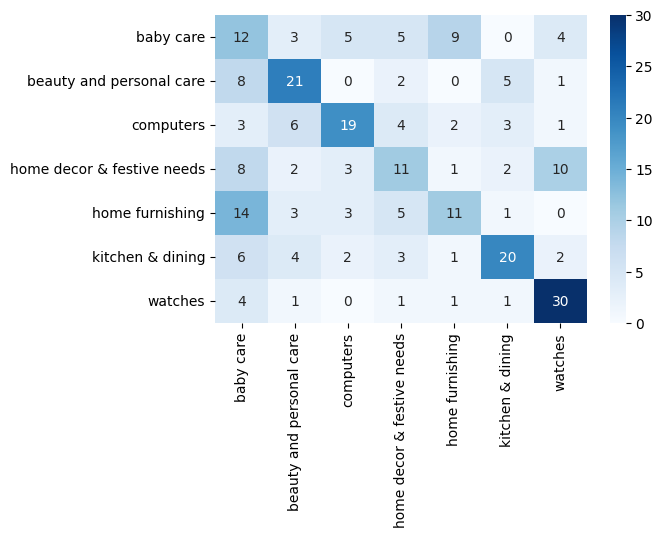

In [26]:
df_cm = pd.DataFrame(conf_mat, index = dataset_test.class_names,
                  columns = dataset_test.class_names)

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Score de classification

In [27]:
print(classification_report(df_comp["category"], df_comp["predicted"]))

                            precision    recall  f1-score   support

                 baby care       0.22      0.32      0.26        38
  beauty and personal care       0.53      0.57      0.55        37
                 computers       0.59      0.50      0.54        38
home decor & festive needs       0.35      0.30      0.32        37
           home furnishing       0.44      0.30      0.35        37
          kitchen & dining       0.62      0.53      0.57        38
                   watches       0.62      0.79      0.70        38

                  accuracy                           0.47       263
                 macro avg       0.48      0.47      0.47       263
              weighted avg       0.48      0.47      0.47       263



Nous avons ici un score F1 global de 73%.

## Analyse des erreurs

La catégorie de produits qui a donné le plus grand taux de faux négatifs est "Beauty and personal care". Visualisons les images correspondantes.

In [28]:
df_comp.loc[(df_comp["category"]=="beauty and personal care") & (df_comp["predicted"]!="beauty and personal care")]

,uniq_id,category,predicted
15,020d2daba55a723128e4e07c0b0393a9,beauty and personal care,home decor & festive needs
23,afc829d45be38102afaa20f4bce2f627,beauty and personal care,kitchen & dining
27,b6c339777814451815fe7950fd4c8536,beauty and personal care,baby care
72,d61b368146f83075937e144dab93c6a1,beauty and personal care,baby care
109,6b5cdfe68595fbcab0e05dc625d3d66a,beauty and personal care,baby care
113,648b52926285610670a756923b8a6f99,beauty and personal care,baby care
138,7821fb1cbf8d3bb294c3c20527119f15,beauty and personal care,baby care
141,9613f2f1e65fb1fc7e181e7f83c217da,beauty and personal care,baby care
170,a11773bc4188f1c6226b941ec61c2024,beauty and personal care,watches
216,23704dd51c975e845c574b044aae0a9f,beauty and personal care,kitchen & dining


In [29]:

for uniq_id, category, predicted in df_comp.loc[(df_comp["category"]=="beauty and personal care") & (df_comp["predicted"]!="beauty and personal care"), ["uniq_id", "category", "predicted"]].values:
    print(f"""{uniq_id} : Prédit "{predicted}" au lieu de "{category}" """)
    img = plt.imread(f'assets/test/{sanitize_filename(category)}/{uniq_id}.jpg')
    imgplot = plt.imshow(img)
    plt.show()

020d2daba55a723128e4e07c0b0393a9 : Prédit "home decor & festive needs" au lieu de "beauty and personal care" 


FileNotFoundError: [Errno 2] No such file or directory: 'assets/test/beauty and personal care/020d2daba55a723128e4e07c0b0393a9.jpg'

In [ ]:
df.loc[df["uniq_id"]=="b6c339777814451815fe7950fd4c8536"]

Parmi les produits mal classifiés, on constate:
- 9613f2f1e65fb1fc7e181e7f83c217da : la photo fait penser à un matelas
- a11773bc4188f1c6226b941ec61c2024 : la photo fait penser à un tableau
- 059493eeb88ebb4cc08d1522f3f87c3f : ressemblance avec un sac d'ordinateur portable


In [ ]:

for uniq_id, category, predicted in df_comp.loc[(df_comp["category"]=="computers") & (df_comp["predicted"]!="computers"), ["uniq_id", "category", "predicted"]].values:
    print(f"""{uniq_id} : Prédit "{predicted}" au lieu de "{category}" """)
    img = plt.imread(f'assets/test/{sanitize_filename(category)}/{uniq_id}.jpg')
    imgplot = plt.imshow(img)
    plt.show()